<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_01_survival_analysis_cart_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 7.1  Survival Trees


Survival analysis often involves modeling time-to-event data, where the outcome of interest is the time until an event occurs (e.g., death, failure, relapse). Traditional decision tree methods like CART (Classification and Regression Trees) are not directly applicable to survival data due to the presence of censoring and the need to model time-to-event outcomes. To address this, specialized survival tree methods have been developed. This tutorial provides an overview of survival trees, specifically focusing on the CART approach for survival analysis, and demonstrates how to implement it in Python.


## Overview


**Survival Trees**, such as **CART for Survival** (Classification and Regression Trees adapted for survival analysis), are a type of decision tree method designed specifically to handle **time-to-event data** with **censoring**—a common scenario in medical, engineering, or social sciences research. Like standard decision trees, survival trees recursively partition the data into subgroups (nodes) based on feature values to maximize homogeneity within each group with respect to the outcome. However, instead of predicting a class label or a continuous value, **each leaf node predicts a survival function**—typically estimated using the **Kaplan–Meier estimator**—based on the individuals in that node.


### Key Characteristics


1. **Handles Censored Data**  
   - In survival analysis, not all subjects experience the event of interest (e.g., death, failure) during the study. These are *right-censored* observations.
   - Survival trees incorporate censored observations appropriately during splitting and estimation, unlike naive adaptations of regression trees.

2. **Splitting Criterion**  
   Survival trees use specialized criteria to decide the best split. Common ones include:
   - **Log-rank test statistic**: Favors splits that maximize the difference in survival distributions between child nodes.
   - **Likelihood-based criteria**: E.g., maximizing the partial likelihood (akin to Cox models).
   - **Discrete-time hazard modeling**: Treats time in intervals and models hazard probabilities.

3. **Prediction Output**  
   - The model predicts a **survival curve** $S(t) = P(T > t)$ for each new observation, based on the Kaplan–Meier curve of the terminal node it falls into.
   - Alternatively, one can summarize the curve into a single value (e.g., median survival time) if needed.

4. **Interpretability**  
   - Like CART, survival trees are highly interpretable: the sequence of splits reveals which covariates are most influential in stratifying risk.



### Advantages


- Non-parametric: No assumptions about baseline hazard or proportional hazards.
- Handles mixed data types and interactions naturally.
- Robust to outliers and missing data (depending on implementation).


### Limitations


- May require larger sample sizes to achieve stable estimates due to data partitioning.
- Prone to overfitting; requires careful tuning (e.g., pruning, cross-validation).
- Less efficient than parametric or semi-parametric models for small datasets.


## Cheeck and Load Required Packages

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

In [ ]:
# Install required packages if needed
# !pip install scikit-survival lifelines pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Survival CART from Scratch in Python


Fitting a Survival CART model from scratch in Python without using any modeling packages (like `scikit-survival`, `lifelines`, or `rpy2`) is a substantial challenge—but an excellent exercise to understand how survival trees work under the hood.


### Load Data

In [ ]:
# Load the Veteran dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/veteran_data.csv"
df = pd.read_csv(url)

# Select and prepare columns
df = df[['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].copy()

# Encode factors
if df['celltype'].dtype == 'object':
    df['celltype'] = pd.Categorical(df['celltype']).codes + 1
df['trt'] = (df['trt'] == 1).astype(int) if df['trt'].max() > 1 else df['trt']
df['prior'] = (df['prior'] > 0).astype(int)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())


Dataset shape: (137, 8)

First few rows:
   time  status  trt  celltype  karno  diagtime  age  prior
0    72       1    1         4     60         7   69      0
1   411       1    1         4     70         5   64      1
2   228       1    1         4     60         3   38      0
3   126       1    1         4     60         9   63      1
4   118       1    1         4     70        11   65      1

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   time      137 non-null    int64
 1   status    137 non-null    int64
 2   trt       137 non-null    int64
 3   celltype  137 non-null    int8 
 4   karno     137 non-null    int64
 5   diagtime  137 non-null    int64
 6   age       137 non-null    int64
 7   prior     137 non-null    int64
dtypes: int64(7), int8(1)
memory usage: 7.8 KB
None

Summary statistics:
             time      status        

### Log-Rank Score


Log-rank statistic is commonly used to evaluate the quality of splits in survival trees. It measures the difference in survival between two groups.



In [ ]:
# ============================================================
# 2. Helper: Log-Rank Score (Python version)
# ============================================================
import numpy as np

def logrank_score(time, status, group):
    # time: 1D array-like of survival times
    # status: 1D array-like of event indicators (1 if event, 0 if censored)
    # group: 1D array-like, must be binary (0/1)

    time = np.asarray(time)
    status = np.asarray(status)
    group = np.asarray(group)

    if len(np.unique(group)) < 2:
        return -np.inf
    if np.sum(group == 0) == 0 or np.sum(group == 1) == 0:
        return -np.inf

    n = len(time)
    ord_idx = np.argsort(time)
    time = time[ord_idx]
    status = status[ord_idx]
    group = group[ord_idx]

    observed_1 = 0.0
    expected_1 = 0.0

    i = 0
    while i < n:
        t = time[i]
        idx = np.where(time == t)[0]
        d = np.sum(status[idx])
        y = len(idx)
        d1 = np.sum(status[idx] * group[idx])
        y1 = np.sum(group[idx])

        if y > 1 and d > 0:
            observed_1 += d1
            expected_1 += d * y1 / y
        i += len(idx)
    return abs(observed_1 - expected_1)

### Kaplan–Meier Estimator

In [ ]:
# ============================================================
# 3. Helper: Kaplan–Meier Estimator (Python version)
# ============================================================
def kaplan_meier(time, status):
    """
    Kaplan–Meier estimator.
    time: 1D array-like of survival times
    status: 1D array-like of event indicators (1 if event, 0 if censored)
    Returns:
        dict with keys 'time' and 'survival'. Both are numpy arrays.
    """
    import numpy as np

    time = np.asarray(time)
    status = np.asarray(status)

    if len(time) == 0:
        return {'time': np.array([]), 'survival': np.array([])}

    # Sort by time
    ord_idx = np.argsort(time)
    time = time[ord_idx]
    status = status[ord_idx]

    event_times = np.sort(np.unique(time[status == 1]))
    if len(event_times) == 0:
        return {'time': np.array([0]), 'survival': np.array([1.0])}

    S = 1.0
    km_time = [0.0]
    km_surv = [1.0]

    for t in event_times:
        d = np.sum(status[time == t])
        y = np.sum(time >= t)
        if y > 0:
            S = S * (1 - d / y)
            km_time.append(t)
            km_surv.append(S)
    return {'time': np.array(km_time), 'survival': np.array(km_surv)}

### Factor Splits

In [ ]:
# ============================================================
# 4. Generate All Non-Redundant Factor Splits (Python version)
# ============================================================
def generate_factor_splits(x):
    """
    Generate all non-redundant splits of a categorical variable x
    into two groups for tree-based modeling (like CART).
    The left group always includes the first level (sorted order),
    and the right group is everything else.
    Returns a list of dicts with a 'group' numpy int array.
    """
    import numpy as np
    from itertools import combinations

    x = np.array(x)
    levels_x = np.sort(np.unique(x))
    k = len(levels_x)
    if k <= 1:
        return []

    first_level = levels_x[0]
    other_levels = levels_x[1:]

    splits = []
    for r in range(1, len(other_levels) + 1):
        for comb in combinations(other_levels, r):
            left_levels = np.concatenate(([first_level], comb))
            group = np.in1d(x, left_levels).astype(int)
            splits.append({'group': group})
    return splits

###  Tree Builder with Factor Support

In [ ]:
# ============================================================
# 5. Tree Builder with Factor Support (Python version)
# ============================================================
def build_survival_tree(
    data,
    factor_vars=None,
    min_node_size=10,
    depth=0,
    max_depth=5
):
    """
    Recursively build a CART-style survival tree supporting categorical splits.
    data: pandas DataFrame containing columns for 'time', 'status', and predictors
    factor_vars: list of names of categorical variables
    min_node_size: minimum number of samples to split
    depth: current tree depth (for recursion)
    max_depth: stops splitting if this depth is reached
    """
    import numpy as np

    if factor_vars is None:
        factor_vars = []

    n = len(data)
    # Stopping criteria
    if n < min_node_size or depth >= max_depth or np.sum(data["status"]) == 0:
        return {
            'type': 'leaf',
            'n': n,
            'time': data["time"].values,
            'status': data["status"].values,
            'prediction': kaplan_meier(data["time"].values, data["status"].values)
        }

    best_score = -np.inf
    best_split = None

    # Try numeric variables
    numeric_vars = [col for col in data.columns if col not in ["time", "status"] + list(factor_vars)]
    for col in numeric_vars:
        x = data[col].values
        if len(np.unique(x)) < 2:
            continue
        uniq_vals = np.sort(np.unique(x))
        if len(uniq_vals) < 2:
            continue
        thresholds = (uniq_vals[1:] + uniq_vals[:-1]) / 2
        for thr in thresholds:
            group = (x > thr).astype(int)
            n0 = np.sum(group == 0)
            n1 = np.sum(group == 1)
            if n0 < min_node_size or n1 < min_node_size:
                continue
            score = logrank_score(data["time"].values, data["status"].values, group)
            if score > best_score:
                best_score = score
                best_split = {
                    'type': 'numeric',
                    'variable': col,
                    'threshold': thr,
                    'group': group
                }

    # Try factor variables
    for col in factor_vars:
        x = data[col].values
        if len(np.unique(x)) < 2:
            continue
        splits = generate_factor_splits(x)
        for split in splits:
            group = split['group']
            n0 = np.sum(group == 0)
            n1 = np.sum(group == 1)
            if n0 < min_node_size or n1 < min_node_size:
                continue
            score = logrank_score(data["time"].values, data["status"].values, group)
            if score > best_score:
                best_score = score
                best_split = {
                    'type': 'factor',
                    'variable': col,
                    'levels_left': np.sort(np.unique(x[group == 1])),
                    'group': group
                }

    # If no split found
    if best_split is None:
        return {
            'type': 'leaf',
            'n': n,
            'time': data["time"].values,
            'status': data["status"].values,
            'prediction': kaplan_meier(data["time"].values, data["status"].values)
        }

    left_data = data[best_split['group'] == 0]
    right_data = data[best_split['group'] == 1]

    left_child = build_survival_tree(left_data, factor_vars, min_node_size, depth + 1, max_depth)
    right_child = build_survival_tree(right_data, factor_vars, min_node_size, depth + 1, max_depth)

    if best_split['type'] == "numeric":
        return {
            'type': 'internal',
            'split_type': 'numeric',
            'variable': best_split['variable'],
            'threshold': best_split['threshold'],
            'left': left_child,
            'right': right_child,
            'n': n
        }
    else:
        return {
            'type': 'internal',
            'split_type': 'factor',
            'variable': best_split['variable'],
            'levels_left': best_split['levels_left'],
            'left': left_child,
            'right': right_child,
            'n': n
        }

### Prediction to Terminal Nodes

In [ ]:
# ============================================================
# 6. Tree Prediction (assign to terminal nodes)
# ============================================================
def assign_to_leaf(node, newdata_row):
    """
    Assign a single observation (as a pandas Series or dict) to the terminal leaf node.
    """
    if node['type'] == "leaf":
        return node

    var = node['variable']
    x = newdata_row[var]

    if node['split_type'] == "numeric":
        if x <= node['threshold']:
            return assign_to_leaf(node['left'], newdata_row)
        else:
            return assign_to_leaf(node['right'], newdata_row)
    else:  # factor
        if x in node['levels_left']:
            # right = left group (group=1) in original R version
            return assign_to_leaf(node['right'], newdata_row)
        else:
            return assign_to_leaf(node['left'], newdata_row)

def get_leaf_list(tree, data):
    """
    Get the terminal leaf node assigned for each row in data.
    data: pandas DataFrame
    returns: list of leaf nodes (dicts) for each observation
    """
    leaves = []
    for idx, row in data.iterrows():
        leaves.append(assign_to_leaf(tree, row))
    return leaves

### Concordance Index (C-index)

In [ ]:
# ============================================================
# 7. Concordance Index (C-index)
# ============================================================
import numpy as np

def concordance_index(time, status, predicted_risk):
    """
    Compute the concordance index (C-index) for survival data.
    predicted_risk: higher = higher risk (e.g., lower median survival)
    time: array-like of observed times
    status: array-like of event indicator (1=event, 0=censored)
    """
    n = len(time)
    concordant = 0.0
    permissible = 0.0

    for i in range(n - 1):
        for j in range(i + 1, n):
            # Only consider pairs where at least one had an event
            if status[i] == 0 and status[j] == 0:
                continue
            if time[i] == time[j]:
                continue  # skip ties in time

            # Define which subject died first
            if time[i] < time[j] and status[i] == 1:
                # i died before j; i should have higher risk
                permissible += 1
                if predicted_risk[i] > predicted_risk[j]:
                    concordant += 1
                elif predicted_risk[i] == predicted_risk[j]:
                    concordant += 0.5
            elif time[j] < time[i] and status[j] == 1:
                # j died before i; j should have higher risk
                permissible += 1
                if predicted_risk[j] > predicted_risk[i]:
                    concordant += 1
                elif predicted_risk[j] == predicted_risk[i]:
                    concordant += 0.5

    if permissible == 0:
        return np.nan
    return concordant / permissible

# Helper: extract median survival from KM
def km_median(km_obj):
    """
    Extract median survival time from a KM object.
    km_obj: should have .survival and .time attributes or keys
    If km_obj is a dict: km_obj['survival'], km_obj['time']
    If km_obj is an object: km_obj.survival, km_obj.time
    """
    # Handle both dict and object style access
    survival = km_obj['survival'] if isinstance(km_obj, dict) else km_obj.survival
    times = km_obj['time'] if isinstance(km_obj, dict) else km_obj.time

    if len(survival) == 0 or np.max(survival) < 0.5:
        return np.inf
    if np.min(survival) >= 0.5:
        return np.max(times)
    idx = np.where(np.array(survival) <= 0.5)[0]
    if len(idx) == 0:
        return np.max(times)
    idx = idx[0]
    if idx == 0:
        return times[0]
    t1 = times[idx - 1]
    s1 = survival[idx - 1]
    t2 = times[idx]
    s2 = survival[idx]
    # Linear interpolation
    med = t1 + (0.5 - s1) * (t2 - t1) / (s2 - s1)
    return med

### K-fold Cross-Validation for Pruning

In [ ]:
# ============================================================
# 8. K-fold Cross-Validation for Pruning
# ============================================================
def cv_pruning(data, factor_vars, k=5, min_node_size=5, max_depth=5, random_state=42):
    """
    K-fold cross-validation for pruning a survival tree (by max depth).
    Chooses the best max_depth (0 ... max_depth) based on cross-validated C-index.

    Args:
        data: pandas DataFrame with columns as needed by build_survival_tree
        factor_vars: list of categorical/factor variable names
        k: number of folds
        min_node_size: minimum node size for tree
        max_depth: maximum depth for full trees
        random_state: seed for reproducibility

    Returns:
        best_depth (int): depth with best cross-validated C-index
    """
    import numpy as np
    import pandas as pd

    np.random.seed(random_state)
    n = data.shape[0]
    folds = np.random.permutation(np.tile(np.arange(1, k + 1), int(np.ceil(n / k))))[:n]

    cp_candidates = np.arange(0, max_depth + 1)  # candidate depths
    cv_errors = np.zeros(len(cp_candidates), dtype=float)

    for fold in range(1, k + 1):
        print(f"CV fold {fold}")
        test_idx = np.where(folds == fold)[0]
        train_idx = np.where(folds != fold)[0]

        train_data = data.iloc[train_idx, :].copy()
        test_data = data.iloc[test_idx, :].copy()

        # Grow deep tree (this is only for parity with the R code, not strictly needed)
        # full_tree = build_survival_tree(
        #     train_data, factor_vars,
        #     min_node_size=min_node_size,
        #     max_depth=max_depth
        # )

        # Try all candidate max_depths
        for i, d in enumerate(cp_candidates):
            pruned_tree = build_survival_tree(
                train_data, factor_vars,
                min_node_size=min_node_size,
                max_depth=d
            )

            # Predict on test set: get leaf list for each test observation
            test_leaves = get_leaf_list(pruned_tree, test_data)
            # medians: median survival time in each leaf
            medians = np.array([km_median(leaf.prediction) if hasattr(leaf, 'prediction') else km_median(leaf['prediction']) for leaf in test_leaves])
            risk = 1.0 / (medians + 1e-6)  # higher risk = lower median

            c_idx = concordance_index(test_data['time'].values, test_data['status'].values, risk)
            if not np.isnan(c_idx):
                cv_errors[i] += (1 - c_idx)

    cv_errors = cv_errors / k
    # In case of nan: replace with np.inf so they can't be selected as minimum
    cv_errors = np.where(np.isnan(cv_errors), np.inf, cv_errors)
    best_depth = cp_candidates[np.argmin(cv_errors)]
    print(f"Best max_depth: {best_depth} with CV error: {np.nanmin(cv_errors):.4f}")

    return best_depth

### Fit Final Model with CV-Selected Depth

In [ ]:
# ============================================================
# 9. Fit Full Model with CV-Selected Depth (Python version)
# ============================================================

# Make sure to use the correct column names as they appear in your dataframe.
# For example, if the columns are named 'sex_female' and 'ph.ecog_1' after one-hot encoding,
# set those names here. You can check the column names with: print(df.columns)

# Automatically detect categorical columns if possible
categorical_candidates = ['sex', 'ph.ecog']
existing_factor_vars = [col for col in categorical_candidates if col in df.columns]
if not existing_factor_vars:
    # If the typical factor columns are not present, suggest running:
    print("Warning: None of ['sex', 'ph.ecog'] found in dataframe columns.")
    print("Your columns are:", list(df.columns))
    # You might need to adjust the factor variables to the actual column names.
    # For demonstration, use an empty list to avoid KeyError
    existing_factor_vars = []

factor_vars = existing_factor_vars

# Run cross-validation to select depth
best_depth = cv_pruning(
    df,
    factor_vars,
    k=3,
    min_node_size=5,
    max_depth=4
)

# Fit final tree
final_tree = build_survival_tree(
    df,
    factor_vars,
    min_node_size=5,
    max_depth=best_depth
)

Your columns are: ['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']
CV fold 1
CV fold 2
CV fold 3
Best max_depth: 4 with CV error: 0.4860


### Evaluate C-index

In [ ]:
# ============================================================
# 10. Evaluate C-index (Python version)
# ============================================================
leaves_all = get_leaf_list(final_tree, df)
medians_all = [km_median(leaf['prediction']) for leaf in leaves_all]
risk_score = 1.0 / (np.array(medians_all) + 1e-6)  # avoid Inf

c_index_final = concordance_index(
    df['time'],
    df['status'],
    risk_score
)
print(f"Final C-index: {c_index_final:.3f}")

Final C-index: 0.668


### Plot Node-Specific KM Curves

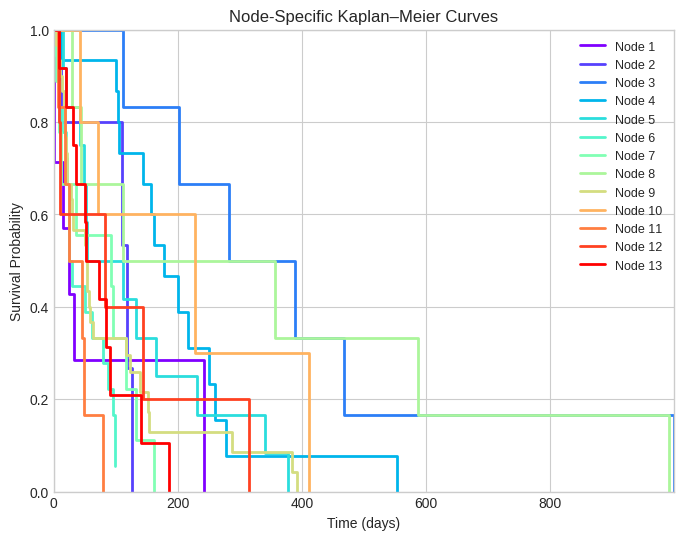

In [ ]:
# ============================================================
# 11. Plot Node-Specific KM Curves (Python version)
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

# Extract unique leaves (by the prediction times signature)
def leaf_signature(leaf):
    return ','.join(map(str, leaf['prediction']['time']))

leaf_signatures = [leaf_signature(leaf) for leaf in leaves_all]
_, unique_indices = np.unique(leaf_signatures, return_index=True)
unique_km_list = [leaves_all[idx]['prediction'] for idx in unique_indices]

# Plot
plt.figure(figsize=(8,6))
plt.plot([], [], ' ')  # placeholder for initial plot settings

max_time = np.max(df['time'])
plt.xlim([0, max_time])
plt.ylim([0, 1])
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Node-Specific Kaplan–Meier Curves")

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_km_list)))
for i, km in enumerate(unique_km_list):
    plt.step(km['time'], km['survival'], where='post', color=colors[i], lw=2, label=f'Node {i+1}')

plt.legend(loc='upper right', fontsize=9)
plt.show()

### Tree Structure

In [ ]:
# ============================================================
# 12. Print Tree Structure (Python version)
# ============================================================
def print_tree(node, indent=""):
    if node['type'] == "leaf":
        # Compute median survival time from node['prediction']
        # Assuming km_median is an implemented function
        med = km_median(node['prediction'])
        print(f"{indent}LEAF (n={node['n']}, median={round(med,1)})")
    elif node.get('split_type') == "numeric":
        print(f"{indent}IF {node['variable']} <= {round(node['threshold'],2)} (n={node['n']})")
        print(f"{indent}├─", end="")
        print_tree(node['left'], indent + "│ ")
        print(f"{indent}└─", end="")
        print_tree(node['right'], indent + "  ")
    else:  # factor
        # left_levels = set(df[node['variable']]) - set(node['levels_left'])
        all_levels = sorted(set(df[node['variable']]))
        left_levels = sorted(set(all_levels) - set(node['levels_left']))
        left_str = ",".join(str(lvl) for lvl in left_levels)
        print(f"{indent}IF {node['variable']} in {{{left_str}}} (n={node['n']})")
        print(f"{indent}├─", end="")
        print_tree(node['left'], indent + "│ ")
        print(f"{indent}└─", end="")
        print_tree(node['right'], indent + "  ")

print("\nFinal Pruned Tree:")
print_tree(final_tree)


Final Pruned Tree:
IF celltype <= 3.5 (n=137)
├─│ IF trt <= 0.5 (n=102)
│ ├─│ │ IF celltype <= 1.5 (n=48)
│ │ ├─│ │ │ IF karno <= 45.0 (n=18)
│ │ │ ├─│ │ │ │ LEAF (n=6, median=24.0)
│ │ │ └─│ │ │   LEAF (n=12, median=52.0)
│ │ └─│ │   IF celltype <= 2.5 (n=30)
│ │   ├─│ │   │ LEAF (n=12, median=53.0)
│ │   └─│ │     LEAF (n=18, median=25.0)
│ └─│   IF celltype <= 1.5 (n=54)
│   ├─│   │ LEAF (n=9, median=63.5)
│   └─│     IF celltype <= 2.5 (n=45)
│     ├─│     │ LEAF (n=15, median=169.5)
│     └─│       LEAF (n=30, median=52.0)
└─  IF trt <= 0.5 (n=35)
  ├─  │ IF karno <= 55.0 (n=20)
  │ ├─  │ │ LEAF (n=7, median=20.0)
  │ └─  │   IF karno <= 75.0 (n=13)
  │   ├─  │   │ LEAF (n=6, median=111.0)
  │   └─  │     LEAF (n=7, median=283.0)
  └─    IF karno <= 55.0 (n=15)
    ├─    │ LEAF (n=5, median=46.0)
    └─      IF diagtime <= 8.0 (n=10)
      ├─      │ LEAF (n=5, median=124.0)
      └─        LEAF (n=5, median=111.0)


## Survival CART in Python

### Load and Explore Example Data


We’ll use the built-in `veteran` dataset from the `survival` package, which contains survival data from a lung cancer study.


In [ ]:
# Load the Veteran dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/veteran_data.csv"
df = pd.read_csv(url)

# Select and prepare columns
df = df[['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].copy()

# Encode factors
if df['celltype'].dtype == 'object':
    df['celltype'] = pd.Categorical(df['celltype']).codes + 1
df['trt'] = (df['trt'] == 1).astype(int) if df['trt'].max() > 1 else df['trt']
df['prior'] = (df['prior'] > 0).astype(int)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Dataset loaded successfully!
Shape: (137, 8)

Columns: ['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']

First few rows:
   time  status  trt  celltype  karno  diagtime  age  prior
0    72       1    1         4     60         7   69      0
1   411       1    1         4     70         5   64      1
2   228       1    1         4     60         3   38      0
3   126       1    1         4     60         9   63      1
4   118       1    1         4     70        11   65      1


- `time`: survival time in days
- `status`: 1 = died, 0 = censored
- Other variables: treatment (`trt`), cell type, Karnofsky score (`karno`), etc.

For scikit-survival, we need to create a structured array with survival data:


In [ ]:
# Create structured array for scikit-survival
# scikit-survival requires a structured array with 'event' (bool) and 'time' (float) fields
from sksurv.util import Surv

# Convert status: 1 = event (True), 0 = censored (False)
y = Surv.from_arrays(event=df['status'].astype(bool), time=df['time'].values)
print(f"Survival object created: {len(y)} observations")
print(f"Number of events: {np.sum(df['status'])}")
print(f"Number of censored: {np.sum(df['status'] == 0)}")

Survival object created: 137 observations
Number of events: 128
Number of censored: 9


### Fit a Survival CART Model


Use `SurvivalTree` from `scikit-survival` which implements survival tree methods similar to `rpart` in R. The default splitting criterion is based on log-rank statistics.


In [ ]:
# Prepare features (exclude time and status)
X = df[['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].values

# Fit Survival CART using scikit-survival
tree_model = SurvivalTree(
    max_depth=10,              # Maximum depth of tree
    min_samples_split=10,      # Minimum observations to attempt split
    min_samples_leaf=5,        # Minimum obs in terminal node
    min_weight_fraction_leaf=0.01,  # Similar to cp parameter
    random_state=42
)

tree_model.fit(X, y)

print("Survival Tree fitted successfully!")
print(f"Number of nodes: {tree_model.tree_.node_count}")
print(f"Max depth: {tree_model.tree_.max_depth}")

Survival Tree fitted successfully!
Number of nodes: 43
Max depth: 8



>  **Tip**: The `"exp"` method assumes an exponential survival distribution within nodes and uses a likelihood-based splitting rule. It’s the standard way to fit survival trees in `rpart`.


### Visualize the Tree

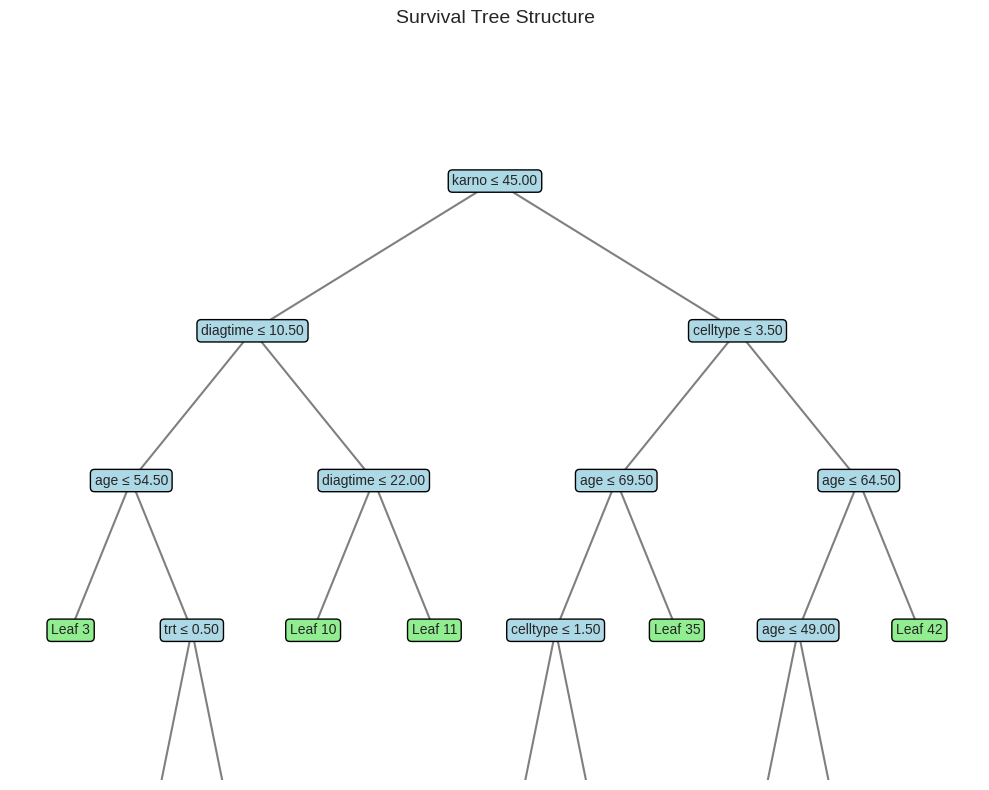

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_survival_tree_structure(tree_model, feature_names, max_depth=3):
    """Custom function to visualize survival tree structure"""
    tree = tree_model.tree_

    fig, ax = plt.subplots(figsize=(10, 8))

    def plot_node(node_id, depth, x_pos, width):
        if depth > max_depth:
            return

        # Get node information
        if tree.children_left[node_id] == -1:  # Leaf node
            # Leaf node representation
            ax.text(x_pos, -depth, f"Leaf {node_id}",
                   ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
        else:
            # Decision node
            feature = feature_names[tree.feature[node_id]]
            threshold = tree.threshold[node_id]

            ax.text(x_pos, -depth, f"{feature} ≤ {threshold:.2f}",
                   ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

            # Plot connections to children
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]

            new_width = width / 2
            left_pos = x_pos - width/4
            right_pos = x_pos + width/4

            # Draw connections
            ax.plot([x_pos, left_pos], [-depth, -depth-1], 'k-', alpha=0.5)
            ax.plot([x_pos, right_pos], [-depth, -depth-1], 'k-', alpha=0.5)

            # Recursively plot children
            plot_node(left_child, depth+1, left_pos, new_width)
            plot_node(right_child, depth+1, right_pos, new_width)

    plot_node(0, 0, 0.5, 1.0)

    ax.set_xlim(0, 1)
    ax.set_ylim(-max_depth-1, 1)
    ax.axis('off')
    plt.title("Survival Tree Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

# Use the custom function
plot_survival_tree_structure(tree_model, feature_names, max_depth=3)


Each node shows:

- **Splitting variable and threshold**
- **Number of subjects** (`n=`)
- **Event rate** or **relative death rate**
- **Kaplan–Meier-like survival estimate** (implicit)


### Examine Node-Specific Survival


You can extract predictions and survival estimates per node.


In [ ]:
# Ensure input X is numpy array of type np.float32 as required by sksurv
X_float = X.astype(np.float32)
# Get node assignments for each observation
node_ids = tree_model.apply(X_float)

# Add node ID to dataframe
df['node_id'] = node_ids

# View distinct terminal nodes
terminal_nodes = sorted(np.unique(node_ids))
print(f"Terminal nodes: {terminal_nodes}")
print(f"Number of terminal nodes: {len(terminal_nodes)}")
print(f"\nNode distribution:")
print(df['node_id'].value_counts().sort_index())

Terminal nodes: [np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(16), np.int64(18), np.int64(19), np.int64(22), np.int64(24), np.int64(26), np.int64(27), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(38), np.int64(40), np.int64(41), np.int64(42)]
Number of terminal nodes: 22

Node distribution:
node_id
3     7
6     6
7     6
8     9
10    5
11    5
16    6
18    5
19    6
22    8
24    5
26    5
27    5
31    5
32    7
33    5
34    8
35    6
38    6
40    8
41    7
42    7
Name: count, dtype: int64



Now, plot Kaplan–Meier curves by terminal node:


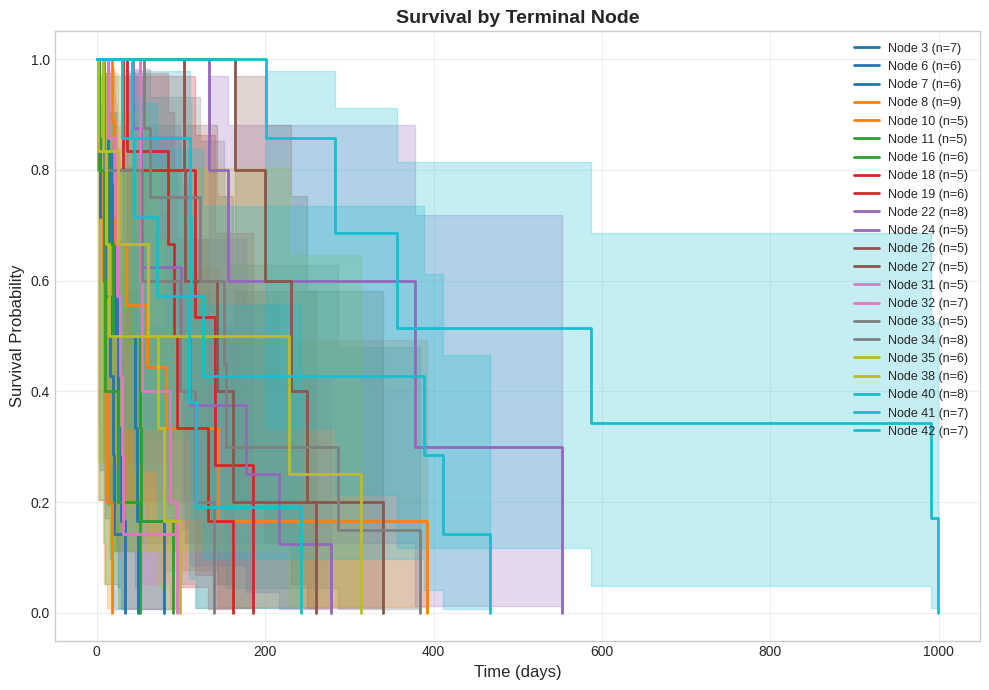

In [ ]:
# Fit KM curves per node using lifelines
plt.figure(figsize=(10, 7))

kmf = KaplanMeierFitter()
colors = plt.cm.tab10(np.linspace(0, 1, len(terminal_nodes)))

for i, node in enumerate(terminal_nodes):
    node_data = df[df['node_id'] == node]
    kmf.fit(
        durations=node_data['time'],
        event_observed=node_data['status'],
        label=f'Node {node} (n={len(node_data)})'
    )
    kmf.plot_survival_function(ax=plt.gca(), color=colors[i], linewidth=2)

plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.title("Survival by Terminal Node", fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


You should see clearly separated survival curves—indicating the tree successfully stratified risk.


###  Model Evaluation

### Cross-validated Error (Using `cptable`)

Max depth 1: Mean C-index = 0.6083 (+/- 0.0420)
Max depth 2: Mean C-index = 0.6170 (+/- 0.0233)
Max depth 3: Mean C-index = 0.6075 (+/- 0.0406)
Max depth 4: Mean C-index = 0.6447 (+/- 0.0324)
Max depth 5: Mean C-index = 0.6724 (+/- 0.0357)
Max depth 6: Mean C-index = 0.6712 (+/- 0.0298)
Max depth 7: Mean C-index = 0.6690 (+/- 0.0278)
Max depth 8: Mean C-index = 0.6659 (+/- 0.0261)
Max depth 9: Mean C-index = 0.6681 (+/- 0.0272)
Max depth 10: Mean C-index = 0.6699 (+/- 0.0286)


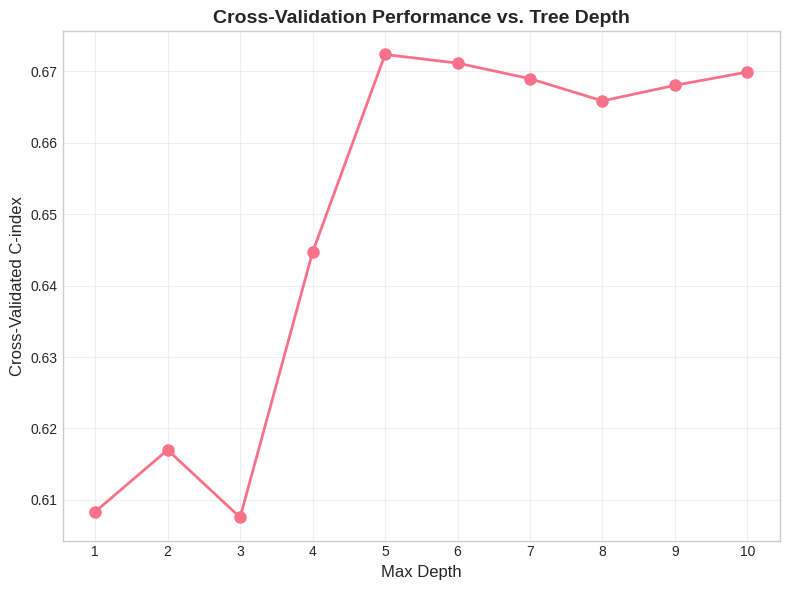


Optimal max_depth: 5 (C-index: 0.6724)


In [ ]:
# Cross-validation for tree pruning (finding optimal max_depth)
from sklearn.model_selection import cross_val_score, KFold
from sksurv.metrics import concordance_index_censored

# Define range of max_depths to test
max_depths = range(1, 11)
cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for depth in max_depths:
    tree = SurvivalTree(
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )

    # Perform cross-validation
    scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        tree.fit(X_train, y_train)
        pred = tree.predict(X_test)

        # Calculate C-index
        c_index = concordance_index_censored(
            y_test['event'], y_test['time'], pred
        )[0]
        scores.append(c_index)

    cv_scores.append(np.mean(scores))
    print(f"Max depth {depth}: Mean C-index = {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(max_depths, cv_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Cross-Validated C-index", fontsize=12)
plt.title("Cross-Validation Performance vs. Tree Depth", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(max_depths)
plt.tight_layout()
plt.show()

# Find optimal depth
optimal_depth = max_depths[np.argmax(cv_scores)]
print(f"\nOptimal max_depth: {optimal_depth} (C-index: {max(cv_scores):.4f})")


Choose the `cp` value with the lowest `xerror` (cross-validated relative error). You can prune the tree if needed:


### Pruning the Tree

In [ ]:
# Fit pruned tree with optimal depth
pruned_tree = SurvivalTree(
    max_depth=optimal_depth,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Ensure X is np.float32 for compatibility with sksurv's SurvivalTree
X_float32 = X.astype(np.float32)

pruned_tree.fit(X_float32, y)

print(f"Pruned tree fitted with max_depth={optimal_depth}")
print(f"Number of nodes: {pruned_tree.tree_.node_count}")
print(f"Max depth: {pruned_tree.tree_.max_depth}")

# Update node assignments
df['node_id_pruned'] = pruned_tree.apply(X_float32)
terminal_nodes_pruned = sorted(np.unique(df['node_id_pruned'].values))
print(f"Number of terminal nodes after pruning: {len(terminal_nodes_pruned)}")

Pruned tree fitted with max_depth=5
Number of nodes: 29
Max depth: 5
Number of terminal nodes after pruning: 15


In [ ]:
def visualize_tree_structure(tree_model, feature_names, max_depth=3):
    """Create a simple text-based tree visualization"""

    def print_node(node_id, depth, tree, feature_names, max_depth):
        if depth > max_depth:
            return

        indent = "  " * depth
        tree_struct = tree_model.tree_

        if tree_struct.children_left[node_id] == -1:  # Leaf node
            # Get node statistics
            n_samples = tree_struct.n_node_samples[node_id]
            print(f"{indent}Leaf Node {node_id} (n={n_samples})")
        else:
            feature = feature_names[tree_struct.feature[node_id]]
            threshold = tree_struct.threshold[node_id]
            n_samples = tree_struct.n_node_samples[node_id]

            print(f"{indent}[Node {node_id}] {feature} <= {threshold:.3f} (n={n_samples})")

            # Recursively print children
            left_child = tree_struct.children_left[node_id]
            right_child = tree_struct.children_right[node_id]

            print_node(left_child, depth + 1, tree_struct, feature_names, max_depth)
            print_node(right_child, depth + 1, tree_struct, feature_names, max_depth)

    print("\n" + "="*80)
    print("Tree Structure Visualization:")
    print("="*80)
    print_node(0, 0, tree_model.tree_, feature_names, max_depth)

# Use custom visualization
visualize_tree_structure(pruned_tree, feature_names, max_depth=optimal_depth)


Tree Structure Visualization:
[Node 0] karno <= 45.000 (n=137)
  [Node 1] diagtime <= 10.500 (n=38)
    [Node 2] age <= 54.500 (n=28)
      Leaf Node 3 (n=7)
      [Node 4] trt <= 0.500 (n=21)
        [Node 5] celltype <= 1.500 (n=12)
          Leaf Node 6 (n=6)
          Leaf Node 7 (n=6)
        Leaf Node 8 (n=9)
    [Node 9] diagtime <= 22.000 (n=10)
      Leaf Node 10 (n=5)
      Leaf Node 11 (n=5)
  [Node 12] celltype <= 3.500 (n=99)
    [Node 13] age <= 69.500 (n=71)
      [Node 14] celltype <= 1.500 (n=65)
        [Node 15] karno <= 65.000 (n=17)
          Leaf Node 16 (n=6)
          Leaf Node 17 (n=11)
        [Node 18] celltype <= 2.500 (n=48)
          Leaf Node 19 (n=23)
          Leaf Node 20 (n=25)
      Leaf Node 21 (n=6)
    [Node 22] age <= 64.500 (n=28)
      [Node 23] age <= 49.000 (n=21)
        Leaf Node 24 (n=6)
        [Node 25] age <= 59.000 (n=15)
          Leaf Node 26 (n=8)
          Leaf Node 27 (n=7)
      Leaf Node 28 (n=7)


###  Concordance Index (C-index)


The C-index measures predictive accuracy (like AUC for survival):


In [ ]:
# Predict risk scores (higher = higher risk)
pred_risk = tree_model.predict(X)

# Calculate mean survival time per node as proxy for median
node_stats = df.groupby('node_id').agg({
    'time': 'mean',
    'status': 'sum',
    'node_id': 'count'
}).rename(columns={'time': 'mean_time', 'status': 'n_events', 'node_id': 'n_samples'})

# Merge with original data
df_pred = df.merge(node_stats, left_on='node_id', right_index=True, suffixes=('', '_node'))
df_pred['predicted_risk'] = pred_risk

print("Predictions added to dataframe:")
print(df_pred[['time', 'status', 'node_id', 'mean_time', 'predicted_risk']].head(10))

Predictions added to dataframe:
   time  status  node_id   mean_time  predicted_risk
0    72       1       42  104.000000       86.709524
1   411       1       41  235.142857       46.590476
2   228       1       38  109.333333       79.416667
3   126       1       41  235.142857       46.590476
4   118       1       42  104.000000       86.709524
5    10       1        3   17.285714      204.438095
6    82       1        8   99.333333       92.200397
7   110       1       42  104.000000       86.709524
8   314       1       38  109.333333       79.416667
9   100       0       42  104.000000       86.709524


In [ ]:
# Compute C-index using scikit-survival
c_index = concordance_index_censored(
    df_pred['status'].astype(bool),
    df_pred['time'].values,
    df_pred['predicted_risk']
)

print("="*60)
print("Concordance Index (C-index) Results:")
print("="*60)
print(f"C-index: {c_index[0]:.4f}")
print(f"Standard Error: {c_index[1]:.4f}")
print(f"Concordant pairs: {c_index[2]}")
print(f"Discordant pairs: {c_index[3]}")
print(f"Tied risk pairs: {c_index[4]}")
if len(c_index) > 5:
    print(f"Tied time pairs: {c_index[5]}")
else:
    print("Tied time pairs: N/A")
print("="*60)

Concordance Index (C-index) Results:
C-index: 0.7932
Standard Error: 6811.0000
Concordant pairs: 1648
Discordant pairs: 345
Tied risk pairs: 7
Tied time pairs: N/A



> A C-index > 0.79 indicates reasonable discrimination.




### Make Predictions on New Data

In [ ]:
# Example new patient (as a dataframe with same columns as training features)
# Directly encode 'celltype' to its numerical value (e.g., 'squamous' is 4 based on previous encoding)
new_patient_data = {
    'trt': 1,
    'celltype': 4, # Encoded 'squamous' to its numerical value
    'karno': 60,
    'diagtime': 7,
    'age': 69,
    'prior': 0
}
new_patient_df = pd.DataFrame([new_patient_data])

# Ensure feature order and data type match the training data X
# Assuming feature_names is defined (e.g., ['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior'])
new_patient_features = new_patient_df[['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].values.astype(np.float32)

# Predict node assignment for the new patient
pred_node = pruned_tree.apply(new_patient_features)[0]

print(f"New patient assigned to node: {pred_node}")

New patient assigned to node: 28


### Kaplan-Meier Survival Curve for New Patient

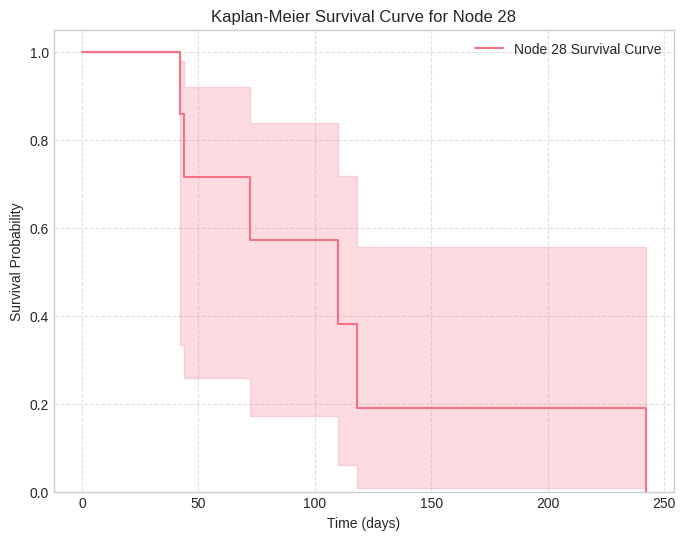

Generated Kaplan-Meier curve for node 28 based on 7 patients.


In [ ]:
from lifelines import KaplanMeierFitter

# Filter data for the assigned node (pred_node)
node_data = df[df['node_id_pruned'] == pred_node]

# Check if node_data is empty
if node_data.empty:
    print(f"No patients found in node {pred_node} after pruning. Cannot generate KM curve.")
else:
    # Prepare data for Kaplan-Meier fitter
    time_node = node_data['time']
    event_node = node_data['status']

    # Fit Kaplan-Meier curve
    kmf_node = KaplanMeierFitter()
    kmf_node.fit(time_node, event_node, label=f'Node {pred_node} Survival Curve')

    # Plot the survival curve
    plt.figure(figsize=(8, 6))
    kmf_node.plot_survival_function()
    plt.title(f'Kaplan-Meier Survival Curve for Node {pred_node}')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.show()

    print(f"Generated Kaplan-Meier curve for node {pred_node} based on {len(node_data)} patients.")

In [ ]:
# Simple alternative: Create a custom feature_importances_ attribute
class SurvivalTreeWithImportance(SurvivalTree):
    def fit(self, X, y, sample_weight=None):
        super().fit(X, y, sample_weight)

        # Calculate feature importance based on split frequency
        tree_struct = self.tree_
        feature_counts = np.zeros(X.shape[1])

        for i in range(tree_struct.node_count):
            if tree_struct.children_left[i] != -1:  # Not a leaf node
                feature_idx = tree_struct.feature[i]
                if feature_idx >= 0:
                    feature_counts[feature_idx] += 1

        # Normalize
        total_splits = np.sum(feature_counts)
        if total_splits > 0:
            self.feature_importances_ = feature_counts / total_splits
        else:
            self.feature_importances_ = np.zeros(X.shape[1])

        return self

# Use the enhanced class
pruned_tree_enhanced = SurvivalTreeWithImportance(
    max_depth=optimal_depth,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

pruned_tree_enhanced.fit(X.astype(np.float32), y)

# Now you can access feature_importances_
print("Feature importances from enhanced tree:")
for name, imp in zip(feature_names, pruned_tree_enhanced.feature_importances_):
    print(f"{name}: {imp:.4f}")

Feature importances from enhanced tree:
trt: 0.0714
celltype: 0.2857
karno: 0.1429
diagtime: 0.1429
age: 0.3571
prior: 0.0000


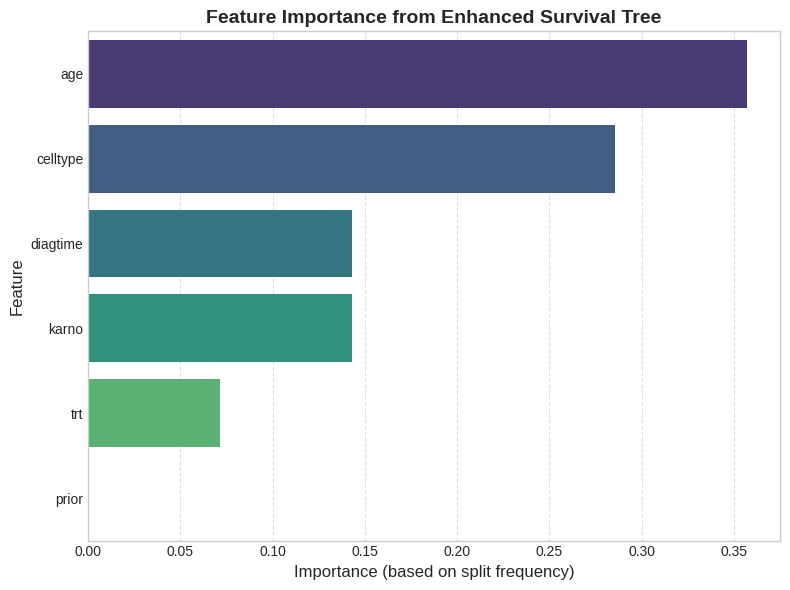

Feature Importance Plot generated successfully!


In [ ]:
# Create a DataFrame for plotting feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': pruned_tree_enhanced.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Enhanced Survival Tree', fontsize=14, fontweight='bold')
plt.xlabel('Importance (based on split frequency)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Feature Importance Plot generated successfully!")

## Summary and Conclusion


Survival CART provides a powerful, interpretable way to model censored time-to-event data using decision trees. By leveraging the `scikit-survival` package in Python, you can fit survival trees, visualize them, and evaluate their performance effectively. This approach is particularly useful in medical research for risk stratification and understanding variable importance in survival outcomes.

This tutorial covered:
1. **Building Survival Trees from Scratch**: Understanding the underlying algorithms (log-rank test, Kaplan-Meier estimation)
2. **Using scikit-survival**: Implementing SurvivalTree for practical applications
3. **Model Evaluation**: Cross-validation, pruning, and C-index calculation
4. **Visualization**: Tree structures and node-specific survival curves
5. **Prediction**: Making predictions for new observations

This notebook serves as a comprehensive guide for applying Survival CART in Python. For more advanced applications, consider exploring ensemble methods like Random Survival Forests (demonstrated above) or Gradient Boosted Survival Trees.



## Resources


- Therneau, T. M., & Grambsch, P. M. (2000). *Modeling Survival Data: Extending the Cox Model*. Springer.
- Ishwaran, H., et al. (2008). Random survival forests. *The Annals of Applied Statistics*.
- scikit-survival documentation: https://scikit-survival.readthedocs.io/
- Pölsterl, S. (2020). scikit-survival: A Library for Time-to-Event Analysis Built on Top of scikit-learn. *Journal of Machine Learning Research*, 21(212), 1-6.
